In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('rfrEjemplo2').getOrCreate()

In [3]:
data = spark.read.csv('insurance.csv', inferSchema=True, header=True)

In [4]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [5]:
data.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [6]:
import pandas as pd

In [7]:
pd.DataFrame(data.take(5), columns=data.columns).transpose()

,0,1,2,3,4
age,19,18,28,33,32
sex,female,male,male,male,male
bmi,27.9,33.77,33.0,22.705,28.88
children,0,1,3,0,0
smoker,yes,no,no,no,no
region,southwest,southeast,southeast,northwest,northwest
charges,16884.924,1725.5523,4449.462,21984.47061,3866.8552


In [8]:
numeric_features = [i[0] for i in data.dtypes if i[1] == 'int' or i[1] == 'double']
data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,1338,39.20702541106129,14.049960379216147,18,64
bmi,1338,30.663396860986538,6.098186911679012,15.96,53.13
children,1338,1.0949177877429,1.205492739781914,0,5
charges,1338,13270.422265141257,12110.011236693992,1121.8739,63770.42801


In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

In [10]:
#SEX
sex_indexer = StringIndexer(inputCol='sex', outputCol='SexIndex')
sex_encoder = OneHotEncoder(inputCol='SexIndex', outputCol='SexVec')

In [11]:
#SMOKER
smoker_indexer = StringIndexer(inputCol='smoker', outputCol='SmokerIndex')
smoker_encoder = OneHotEncoder(inputCol='SmokerIndex', outputCol='SmokerVec')

In [12]:
#REGION
region_indexer = StringIndexer(inputCol='region', outputCol='RegionIndex')
region_encoder = OneHotEncoder(inputCol='RegionIndex', outputCol='RegionVec')

In [13]:
assembler = VectorAssembler(inputCols=['age', 'SexVec', 'bmi', 'children', 'SmokerVec', 'RegionVec'], 
                            outputCol='features')

In [14]:
from pyspark.ml.regression import RandomForestRegressor

In [15]:
random_forest = RandomForestRegressor(featuresCol='features',labelCol='charges')

In [16]:
# Consiste en procesar los datos que están en vectores, assembler y lo utilizados en el modelo random forest
pipeline = Pipeline(stages=[sex_indexer, sex_encoder, 
                            smoker_indexer, smoker_encoder,
                            region_indexer,region_encoder,
                            assembler, random_forest])

In [17]:
train_data,test_data = data.randomSplit([0.7,0.3])

In [18]:
# fit del modelo con la data de entrenamiento
model = pipeline.fit(train_data)

In [19]:
#resultado del modelo con la data de prueba
result = model.transform(test_data)

In [20]:
pd.DataFrame(result.take(20), columns=result.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
age,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
sex,female,female,female,female,female,female,female,female,female,female,female,female,male,male,male,male,male,male,male,male
bmi,26.315,27.28,31.13,31.92,32.12,33.155,33.88,35.625,36.85,38.28,38.28,40.26,21.78,23.32,23.75,25.175,26.125,29.37,31.68,33.66
children,0,3,0,0,2,0,0,0,0,0,0,0,2,1,0,0,0,1,2,0
smoker,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,yes,no
region,northeast,southeast,southeast,northeast,southeast,northeast,southeast,northeast,southeast,southeast,southeast,southeast,southeast,southeast,northeast,northeast,northeast,southeast,southeast,southeast
charges,2198.18985,18223.4512,1621.8827,2205.9808,2801.2588,2207.69745,11482.63485,2211.13075,1629.8335,1631.8212,14133.03775,1634.5734,11884.04858,1711.0268,1705.6245,15518.18025,1708.92575,1719.4363,34303.1672,1136.3994
SexIndex,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SexVec,(0.0),(0.0),(0.0),(0.0),(0.0),(0.0),(0.0),(0.0),(0.0),(0.0),(0.0),(0.0),(1.0),(1.0),(1.0),(1.0),(1.0),(1.0),(1.0),(1.0)
SmokerIndex,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [21]:
result.select('features', 'prediction').show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|(8,[0,2,4],[18.0,...| 4305.326774253952|
|(8,[0,2,3,5],[18....|19340.707777267166|
|(8,[0,2,4,5],[18....| 4417.077342055359|
|(8,[0,2,4],[18.0,...| 4688.514767862784|
|[18.0,0.0,32.12,2...|  5352.97390067054|
|(8,[0,2,4],[18.0,...| 4688.514767862784|
|(8,[0,2,4,5],[18....| 4385.842270763226|
|(8,[0,2,4],[18.0,...| 5071.112027641058|
|(8,[0,2,4,5],[18....|  4391.96711460518|
|(8,[0,2,4,5],[18....|  4391.96711460518|
|(8,[0,2,4,5],[18....|  4391.96711460518|
|(8,[0,2,4,5],[18....|  4391.96711460518|
|[18.0,1.0,21.78,2...| 4894.014426121584|
|[18.0,1.0,23.32,1...| 4108.709578848925|
|(8,[0,1,2,4],[18....|3862.1446411108104|
|(8,[0,1,2],[18.0,...|17692.629363562413|
|(8,[0,1,2,4],[18....| 4161.655800683685|
|[18.0,1.0,29.37,1...| 4473.547142169959|
|[18.0,1.0,31.68,2...| 34594.45868298586|
|[18.0,1.0,33.66,0...| 4219.366412744281|
+--------------------+------------

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol='charges', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(result)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# porcentaje que se puede equivocar el modelo.

Root Mean Squared Error (RMSE) on test data = 5033.55


In [23]:
evaluator = RegressionEvaluator(
    labelCol='charges', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(result)
print("R2 on test data = %g" % r2)

# Que tan cerca está de la regresión o que tan fiable es el modelo.
# entre más cerca de 1 mejor es.

R2 on test data = 0.824074


In [24]:
evaluator = RegressionEvaluator(
    labelCol='charges', predictionCol='prediction', metricName='mae')
mae = evaluator.evaluate(result)
print("MSE on test data = %g" % mae)

# mide la cantidad de error que hay entre dos conjuntos de datos.

MSE on test data = 3037.88


In [25]:
new_charges = spark.read.csv('new_data_insurance.csv',inferSchema=True,header=True)

In [26]:
new_charges.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)



In [27]:
test_new_data = model.transform(new_charges)

In [28]:
test_new_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- SexIndex: double (nullable = false)
 |-- SexVec: vector (nullable = true)
 |-- SmokerIndex: double (nullable = false)
 |-- SmokerVec: vector (nullable = true)
 |-- RegionIndex: double (nullable = false)
 |-- RegionVec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [29]:
test_new_data.select('age','SmokerVec','children','prediction').show()

+---+-------------+--------+------------------+
|age|    SmokerVec|children|        prediction|
+---+-------------+--------+------------------+
| 22|(1,[0],[1.0])|       0| 4566.683823680447|
| 23|    (1,[],[])|       1| 36322.16315713396|
| 67|(1,[0],[1.0])|       4|12985.139750172437|
| 89|    (1,[],[])|       5|27640.036776398378|
+---+-------------+--------+------------------+



In [30]:
test_new_data.select('region','prediction').show()

+---------+------------------+
|   region|        prediction|
+---------+------------------+
|southeast| 4566.683823680447|
|southwest| 36322.16315713396|
|northwest|12985.139750172437|
|northeast|27640.036776398378|
+---------+------------------+



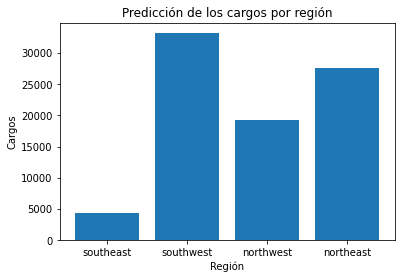

In [31]:
import matplotlib.pyplot as plt

x = ['southeast','southwest','northwest','northeast']
y = [4429.1513,33184.9250,19278.4144,27688.0332 ]
plt.bar(x,y)
plt.ylabel('Cargos')
plt.xlabel('Región')
plt.title('Predicción de los cargos por región')
plt.show()

# Ejercicio desarrollado por: 
# Melva Romero
# Abdiel Banegas
# Kilby Chacón